## miscellanous import

In [ ]:
import gzip
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from statistics import median
from __future__ import annotations
from typing import Any, Dict, Optional
from datetime import datetime, timezone

## Read in the data

In [1]:
import json, gzip
from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
import pandas as pd

DATA_DIR = Path("data")
IN_JSON = DATA_DIR / "dataset0.json.gz"
IN_LABELS = DATA_DIR / "data.info.labelled"
OUT_CSV = DATA_DIR / "features_dataset0.csv"

label_dtypes = {
    "gene_id": "string",
    "transcript_id": "string",
    "transcript_position": "int32",
    "label": "int8",
}
df_info = pd.read_csv(IN_LABELS, dtype=label_dtypes)

lab_map: Dict[Tuple[str, int], Tuple[str, int]] = {
    (row.transcript_id, int(row.transcript_position)): (row.gene_id, int(row.label))
    for row in df_info.itertuples(index=False)
}
def iter_records_gz(path: Path):
    with gzip.open(path, "rt", encoding="utf-8") as f:
        # Try JSON Lines
        first = f.readline()
        if not first:
            return
        first_stripped = first.strip()
        if first_stripped.startswith("{"):
            # JSONL: yield first parsed + rest line-by-line
            yield json.loads(first_stripped)
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)
        else:
            # Whole JSON doc (array or dict)
            f.seek(0)
            data = json.load(f)
            if isinstance(data, list):
                for obj in data:
                    yield obj
            else:
                yield data

# ---------- Feature aggregation helpers ----------
STAT_FUNCS = {
    "mean": np.nanmean,
    "std":  lambda x: np.nanstd(x, ddof=0),
    "median": np.nanmedian,
    "q25":  lambda x: np.nanpercentile(x, 25),
    "q75":  lambda x: np.nanpercentile(x, 75),
    "min":  np.nanmin,
    "max":  np.nanmax,
}
def iqr(x): 
    q75 = np.nanpercentile(x, 75)
    q25 = np.nanpercentile(x, 25)
    return q75 - q25

def agg_all(reads_np: np.ndarray) -> Dict[str, float]:
    """
    reads_np: shape (n_reads, 9) -> triplets per position:
      indices 0..2: m1_(dt,sd,mean), 3..5: c_(dt,sd,mean), 6..8: p1_(dt,sd,mean)
    Returns dict of aggregated stats per (position, feature, stat).
    """
    out = {}
    if reads_np.size == 0:
        return out
    # Split columns
    cols = {
        "m1": reads_np[:, 0:3],   # dt, sd, mean
        "c":  reads_np[:, 3:6],
        "p1": reads_np[:, 6:9],
    }
    feats = ["dt", "sd", "mean"]
    for pos, mat in cols.items():
        for j, fname in enumerate(feats):
            vec = mat[:, j].astype(float)
            vec = np.where(np.isfinite(vec), vec, np.nan)
            # core stats
            for sname, fn in STAT_FUNCS.items():
                try:
                    out[f"{pos}_{fname}_{sname}"] = float(fn(vec))
                except Exception:
                    out[f"{pos}_{fname}_{sname}"] = np.nan
            # iqr
            try:
                out[f"{pos}_{fname}_iqr"] = float(iqr(vec))
            except Exception:
                out[f"{pos}_{fname}_iqr"] = np.nan
    # coverage
    out["n_reads"] = int(reads_np.shape[0])
    return out

def parse_heptamer_5mers(heptamer: str) -> Tuple[str, str, str]:
    """
    From 7-mer (e.g., 'AAGACCA'):
      m1_5mer = heptamer[0:5] -> 'AAGAC'
      center_5mer = heptamer[1:6] -> 'AGACC'
      p1_5mer = heptamer[2:7] -> 'GACCA'
    """
    h = heptamer.upper()
    if len(h) != 7:
        # fallback: keep strings safe
        return "", h[0:5] if len(h)>=5 else "", ""
    return h[0:5], h[1:6], h[2:7]

# ---------- Main aggregation ----------
rows: List[Dict] = []
n_total = 0
for obj in iter_records_gz(IN_JSON):
    n_total += 1
    # Structure: { transcript_id: { position: { heptamer: [[9], [9], ...] } } }
    tid = next(iter(obj))
    pos_map = obj[tid]
    pos_key = next(iter(pos_map))
    pos = int(pos_key)
    hept_map = pos_map[str(pos)] if str(pos) in pos_map else pos_map[pos]
    heptamer = next(iter(hept_map))
    reads = hept_map[heptamer]

    # Clean reads to numeric 9-dim rows
    clean = []
    for r in reads:
        if isinstance(r, (list, tuple)) and len(r) == 9:
            try:
                clean.append([float(x) for x in r])
            except Exception:
                continue
    if not clean:
        continue
    R = np.asarray(clean, dtype=float)  # (n_reads, 9)

    # 5-mers
    m1_5mer, center_5mer, p1_5mer = parse_heptamer_5mers(heptamer)

    # Aggregate stats
    stats = agg_all(R)

    # Label/gene if available
    gid, lab = (None, None)
    key = (tid, pos)
    if key in lab_map:
        gid, lab = lab_map[key]

    row = {
        "gene_id": gid,
        "transcript_id": tid,
        "transcript_position": pos,
        "heptamer": heptamer,
        "m1_5mer": m1_5mer,          # NEW
        "center_5mer": center_5mer,
        "p1_5mer": p1_5mer,          # NEW
        "label": lab,                # 0/1 where known; NaN otherwise
        **stats,                    # includes n_reads
    }
    rows.append(row)

df_out = pd.DataFrame(rows)

# Optional: tidy dtypes
if "transcript_position" in df_out:
    df_out["transcript_position"] = df_out["transcript_position"].astype("int32")
if "label" in df_out:
    # Keep NaN for unlabeled; convert only the valid ones
    df_out.loc[df_out["label"].notna(), "label"] = df_out.loc[df_out["label"].notna(), "label"].astype(int)

# Ensure no 'is_drach' column is present
if "is_drach" in df_out.columns:
    df_out = df_out.drop(columns=["is_drach"])

# Write CSV
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(OUT_CSV, index=False)
print(f"Wrote: {OUT_CSV} | rows={len(df_out)} | from_records={n_total}")
# Quick peek
print(df_out.head(3))


Wrote: data\features_dataset0.csv | rows=121838 | from_records=121838
           gene_id    transcript_id  transcript_position heptamer m1_5mer  \
0  ENSG00000004059  ENST00000000233                  244  AAGACCA   AAGAC   
1  ENSG00000004059  ENST00000000233                  261  CAAACTG   CAAAC   
2  ENSG00000004059  ENST00000000233                  316  GAAACAG   GAAAC   

  center_5mer p1_5mer  label  m1_dt_mean  m1_dt_std  ...  p1_sd_iqr  \
0       AGACC   GACCA      0    0.008264   0.005384  ...     3.7300   
1       AAACT   AACTG      0    0.006609   0.003588  ...     1.3225   
2       AAACA   AACAG      0    0.007570   0.004444  ...     0.9000   

   p1_mean_mean  p1_mean_std  p1_mean_median  p1_mean_q25  p1_mean_q75  \
0     80.570270     2.522168            80.5         79.0       82.000   
1     94.290698     2.492530            94.1         92.8       95.725   
2     89.364324     1.484341            89.2         88.4       90.100   

   p1_mean_min  p1_mean_max  p1_mean_iq

## Helper functions

In [8]:
# Minimal save + evaluate helpers

from pathlib import Path
from datetime import datetime
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ---------- Saving ----------
def save_model_minimal(model, name="model", models_dir="models"):
    Path(models_dir).mkdir(parents=True, exist_ok=True)
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    path = Path(models_dir) / f"{name}_{ts}.joblib"
    joblib.dump(model, path)
    print(f"Saved: {path}")
    return path

# ---------- Evaluation (ROC + PRC + F1/Youden) ----------
def _safe_f1_vec(prec, rec):
    denom = prec + rec
    out = np.zeros_like(denom, dtype=float)
    m = denom > 0
    out[m] = 2 * (prec[m] * rec[m]) / denom[m]
    return out

def eval_scores(y_true, y_score, plot_prefix=None):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score, dtype=float).ravel()

    # ROC
    fpr, tpr, thr_roc = roc_curve(y_true, y_score)
    auroc = roc_auc_score(y_true, y_score)
    j_vals = tpr - fpr
    j_idx = int(np.argmax(j_vals))
    thr_youden = float(thr_roc[j_idx])

    # PRC
    precision, recall, thr_pr = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    f1_vals = _safe_f1_vec(precision[:-1], recall[:-1])
    f1_idx = int(np.argmax(f1_vals))
    thr_f1 = float(thr_pr[f1_idx])

    # Plots
    # ROC
    plt.figure(figsize=(5.2, 4.2))
    plt.plot(fpr, tpr, label=f"AUROC={auroc:.3f}")
    plt.plot([0, 1], [0, 1], "--", lw=1)
    plt.scatter(fpr[j_idx], tpr[j_idx], marker="x", s=70, label=f"Youden thr={thr_youden:.3f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.legend(); plt.tight_layout()
    if plot_prefix: plt.savefig(f"{plot_prefix}_roc.png", dpi=150)
    plt.show()

    # PR
    plt.figure(figsize=(5.2, 4.2))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.scatter(recall[f1_idx], precision[f1_idx], marker="x", s=70, label=f"Max-F1 thr={thr_f1:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve"); plt.legend(); plt.tight_layout()
    if plot_prefix: plt.savefig(f"{plot_prefix}_pr.png", dpi=150)
    plt.show()

    # Summaries at thresholds
    def _summary_at(thr):
        yp = (y_score >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        return {
            "threshold": float(thr),
            "precision": float(precision_score(y_true, yp, zero_division=0)),
            "recall": float(recall_score(y_true, yp, zero_division=0)),
            "f1": float(f1_score(y_true, yp, zero_division=0)),
            "accuracy": float(accuracy_score(y_true, yp)),
            "tp": int(tp), "fp": int(fp), "tn": int(tn), "fn": int(fn),
        }

    out = {
        "auroc": float(auroc),
        "average_precision": float(ap),
        "best_f1_threshold": thr_f1,
        "youden_threshold": thr_youden,
        "at_best_f1": _summary_at(thr_f1),
        "at_youden": _summary_at(thr_youden),
    }
    return out

def evaluate_sklearn_minimal(model, X_test, y_test, plot_prefix=None):
    """Works with sklearn classifiers that implement predict_proba"""
    y_score = model.predict_proba(X_test)[:, 1]
    return eval_scores(y_test, y_score, plot_prefix=plot_prefix)

def evaluate_keras_minimal(model, X_test, y_test, plot_prefix=None):
    """For Keras models that output probabilities with model.predict()"""
    y_score = model.predict(X_test).ravel()
    return eval_scores(y_test, y_score, plot_prefix=plot_prefix)

def save_keras_minimal(model, name="keras_model", models_dir="models"):
    Path(models_dir).mkdir(parents=True, exist_ok=True)
    ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")
    path = Path(models_dir) / f"{name}_{ts}.keras"
    model.save(path)
    print(f"Saved: {path}")
    return path


# ---------- Example usage in a cell ----------
# pipe.fit(X_train, y_train)
# summary = evaluate_sklearn_minimal(pipe, X_test, y_test, plot_prefix="models/logreg")
# save_model_minimal(pipe, name="m6a_logreg")
# summary

## EDA

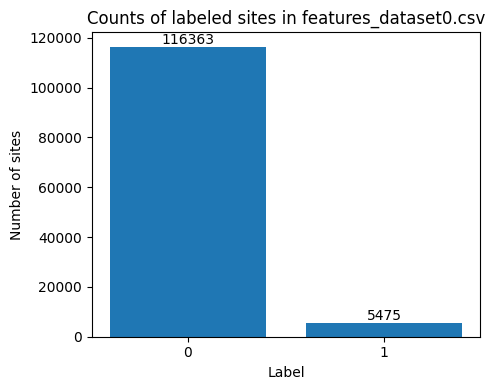

In [3]:
FEATURES_PATH = Path("data/features_dataset0.csv")

df = pd.read_csv(FEATURES_PATH)

df = df[df["label"].isin([0, 1])].copy()

counts = df["label"].value_counts().sort_index()
counts_df = pd.DataFrame({
    "label": ["0", "1"],
    "count": [int(counts.get(0, 0)), int(counts.get(1, 0))],
})

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(counts_df["label"], counts_df["count"])
ax.set_title("Counts of labeled sites in features_dataset0.csv")
ax.set_xlabel("Label")
ax.set_ylabel("Number of sites")

for i, v in enumerate(counts_df["count"]):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

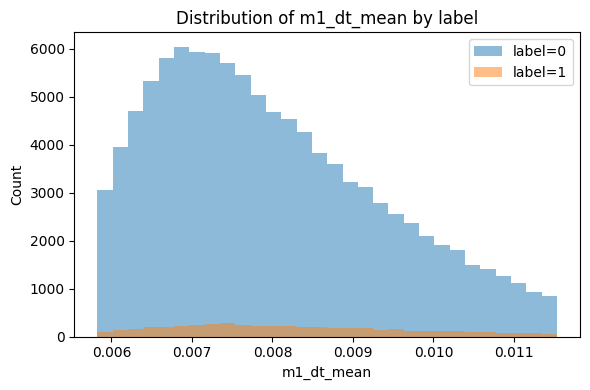

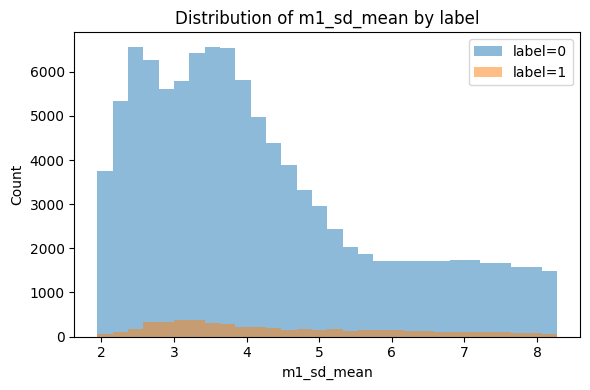

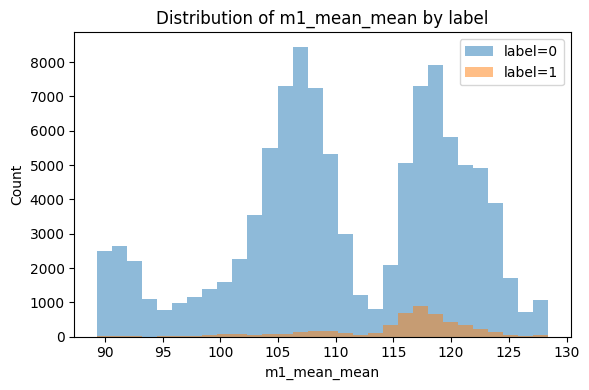

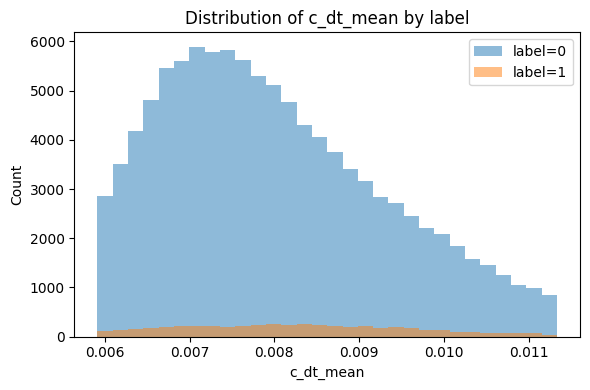

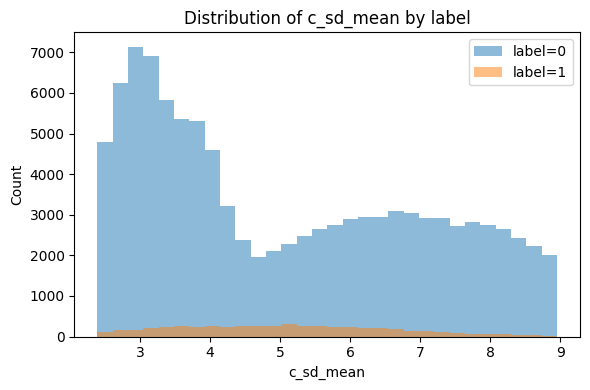

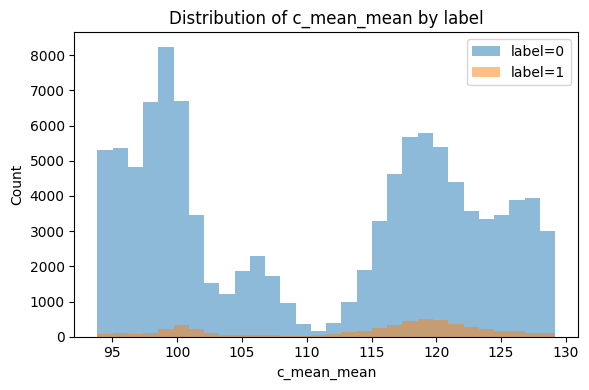

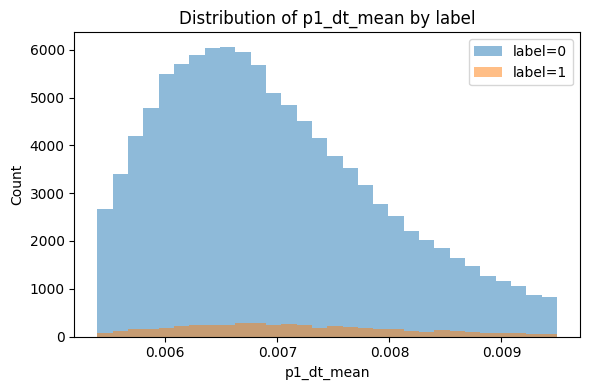

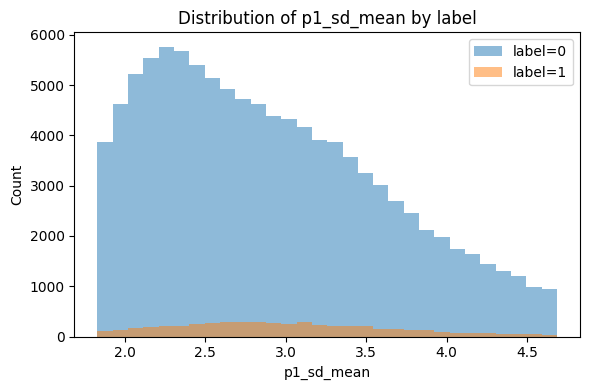

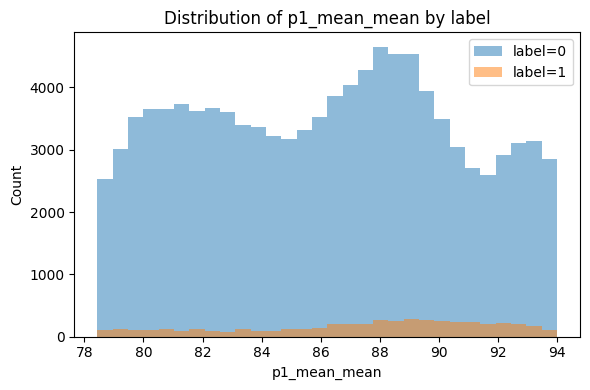

     feature  label  count       mean     median       std
   c_dt_mean      0 116363   0.008120   0.007819  0.001695
   c_dt_mean      1   5475   0.008278   0.008167  0.001634
 c_mean_mean      0 116363 110.761911 113.914286 12.539069
 c_mean_mean      1   5475 114.864291 118.100000  9.865094
   c_sd_mean      0 116363   5.161425   4.626129  2.208171
   c_sd_mean      1   5475   5.075140   5.012651  1.585414
  m1_dt_mean      0 116363   0.008094   0.007745  0.001782
  m1_dt_mean      1   5475   0.008405   0.008124  0.001850
m1_mean_mean      0 116363 110.541661 109.659468 11.375477
m1_mean_mean      1   5475 116.054781 117.206897  7.551773
  m1_sd_mean      0 116363   4.327787   3.824000  1.940280
  m1_sd_mean      1   5475   4.646910   4.174211  1.822596
  p1_dt_mean      0 116363   0.007046   0.006810  0.001295
  p1_dt_mean      1   5475   0.007283   0.007078  0.001301
p1_mean_mean      0 116363  86.173792  86.417840  4.936160
p1_mean_mean      1   5475  86.830278  87.964667  4.9209

In [4]:
base_feats = ["m1_dt","m1_sd","m1_mean","c_dt","c_sd","c_mean","p1_dt","p1_sd","p1_mean"]
stat_suffix = "_mean"

summary_rows = []
outdir = Path("eda_feature_dists")
outdir.mkdir(parents=True, exist_ok=True)

for base in base_feats:
    col = f"{base}{stat_suffix}"
    if col not in df.columns:
        print(f"[skip] {col} not found")
        continue

    d0 = df.loc[df["label"] == 0, col].replace([np.inf, -np.inf], np.nan).dropna()
    d1 = df.loc[df["label"] == 1, col].replace([np.inf, -np.inf], np.nan).dropna()

    # stats table
    for lbl, series in [(0, d0), (1, d1)]:
        mu = float(np.mean(series)) if len(series) else np.nan
        med = float(np.median(series)) if len(series) else np.nan
        sd = float(np.std(series, ddof=1)) if len(series) > 1 else (0.0 if len(series)==1 else np.nan)
        summary_rows.append({"feature": col, "label": lbl, "count": int(len(series)), "mean": mu, "median": med, "std": sd})

    # pick a robust plotting range to avoid extreme tails
    combined = pd.concat([d0, d1], axis=0)
    if len(combined) >= 10:
        lo, hi = np.quantile(combined, [0.05, 0.95])
        if lo == hi:
            lo, hi = combined.min(), combined.max()
    else:
        lo, hi = (combined.min() if len(combined) else 0.0, combined.max() if len(combined) else 1.0)

    fig, ax = plt.subplots(figsize=(6,4))
    if len(d0): ax.hist(d0, bins=30, alpha=0.5, range=(lo, hi), label="label=0")
    if len(d1): ax.hist(d1, bins=30, alpha=0.5, range=(lo, hi), label="label=1")
    ax.set_title(f"Distribution of {col} by label")
    ax.set_xlabel(col); ax.set_ylabel("Count")
    ax.legend()
    plt.tight_layout()
    plt.savefig(outdir / f"{col}_hist.png", dpi=150)
    plt.show()

summary_df = pd.DataFrame(summary_rows).sort_values(["feature","label"]).reset_index(drop=True)
print(summary_df.to_string(index=False))
summary_df.to_csv(outdir / "feature_distribution_summary.csv", index=False)
print(f"Saved figures and summary to: {outdir}")

## Preparing data

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# ---------- Config ----------
FEATURES_PATH = Path("data/features_dataset0.csv")
TEST_SIZE = 0.20

# ---------- Load ----------
df = pd.read_csv(FEATURES_PATH)

# Keep only labeled rows
df = df[df["label"].isin([0, 1])].copy()
df["label"] = df["label"].astype(int)

# ---------- Engineer center–flank features (if source cols exist) ----------
# We use *_mean columns for deltas/ratios; skip gracefully if missing.
def add_center_flank_features(dfx: pd.DataFrame) -> pd.DataFrame:
    def safe_add_delta_ratio(df_, base: str):
        # base in {"dt","sd","mean"}; columns like c_dt_mean, m1_dt_mean, p1_dt_mean
        cm = f"c_{base}_mean"
        m1m = f"m1_{base}_mean"
        p1m = f"p1_{base}_mean"
        if cm in df_.columns and m1m in df_.columns:
            df_[f"delta_c_minus_m1_{base}"] = df_[cm] - df_[m1m]
            df_[f"ratio_c_over_m1_{base}"] = df_[cm] / (df_[m1m].replace(0, np.nan))
        if cm in df_.columns and p1m in df_.columns:
            df_[f"delta_c_minus_p1_{base}"] = df_[cm] - df_[p1m]
            df_[f"ratio_c_over_p1_{base}"] = df_[cm] / (df_[p1m].replace(0, np.nan))
    for b in ["dt", "sd", "mean"]:
        safe_add_delta_ratio(dfx, b)
    # Coverage transforms
    if "n_reads" in dfx.columns:
        dfx["log1p_n_reads"] = np.log1p(dfx["n_reads"].clip(lower=0))
    return dfx

df = add_center_flank_features(df)

# Replace infs created by ratios with NaN (will be imputed later)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# ---------- Define identifiers, target, and candidate features ----------
id_cols = [c for c in ["transcript_id", "transcript_position", "heptamer", "center_5mer"] if c in df.columns]
target_col = "label"

# numeric features (keep is_drach, n_reads, engineered cols, and all numeric aggregates)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target from feature list
feature_cols = [c for c in num_cols if c != target_col]

# Sanity checks
if not feature_cols:
    raise ValueError("No numeric feature columns found. Check your features_dataset0.csv.")

if "transcript_id" not in df.columns:
    # If transcript_id missing, fall back to random split (not ideal)
    print("[WARN] transcript_id not found; using random split without grouping.")
    groups = np.arange(len(df))
else:
    groups = df["transcript_id"].astype(str).values

# ---------- Group-aware split (by transcript) ----------
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE)
train_idx, test_idx = next(gss.split(df, df[target_col].values, groups=groups))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

# ---------- Build X/y ----------
X_train_df = train_df[feature_cols].copy()
X_test_df  = test_df[feature_cols].copy()
Y_train = train_df[target_col].astype(int).values
Y_test  = test_df[target_col].astype(int).values

# ---------- Preprocessing pipeline: median impute + standardize (fit on train only) ----------
preproc = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

X_train = preproc.fit_transform(X_train_df)
X_test  = preproc.transform(X_test_df)

# ---------- Report ----------
print(f"Train size: {X_train.shape[0]} sites, Test size: {X_test.shape[0]} sites")
print(f"Features: {X_train.shape[1]} columns")
print("Positive rate (train): {:.3f}".format(Y_train.mean()))
print("Positive rate (test):  {:.3f}".format(Y_test.mean()))

feature_names = feature_cols
scaler_pipeline = preproc


Train size: 97971 sites, Test size: 23867 sites
Features: 87 columns
Positive rate (train): 0.046
Positive rate (test):  0.042


In [6]:
# === Random undersampling of negatives on the TRAIN split ===

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

NEG_PER_POS = 3
RANDOM_STATE = 42

# 1) Build undersampled training dataframe
pos_df = train_df[train_df[target_col] == 1]
neg_df = train_df[train_df[target_col] == 0]

n_pos = len(pos_df)
n_neg_target = min(len(neg_df), NEG_PER_POS * n_pos)
neg_sample = neg_df.sample(n=n_neg_target, random_state=RANDOM_STATE)

train_df_us = (
    pd.concat([pos_df, neg_sample], axis=0)
      .sample(frac=1.0, random_state=RANDOM_STATE)   # shuffle
      .reset_index(drop=True)
)

print(f"[undersample] positives: {len(pos_df)} | negatives kept: {n_neg_target} "
      f"(from {len(neg_df)}) | total: {len(train_df_us)} "
      f"| pos rate: {train_df_us[target_col].mean():.3f}")

# 2) Build X/y for undersampled train
X_train_df_us = train_df_us[feature_cols].copy()
Y_train_us    = train_df_us[target_col].astype(int).values

# 3) Preprocess (fit on undersampled train only) and transform test with the same scaler
preproc_us = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

X_train_us = preproc_us.fit_transform(X_train_df_us)
X_test_us  = preproc_us.transform(X_test_df)

print(f"X_train_us: {X_train_us.shape}, X_test_us: {X_test_us.shape}")

# Now you can train on (X_train_us, Y_train_us) and evaluate on (X_test_us, Y_test).
# Tip: when using undersampling, you can often set class_weight=None (or keep 'balanced'—both are fine to try).


[undersample] positives: 4339 | negatives kept: 13017 (from 93939) | total: 17356 | pos rate: 0.250
X_train_us: (17356, 87), X_test_us: (23560, 87)


## Now is the fucking training part

### Logistic Regression

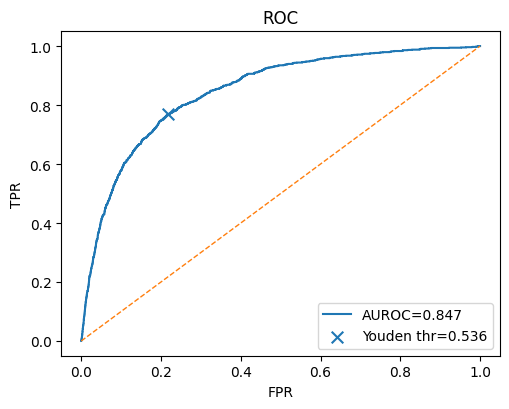

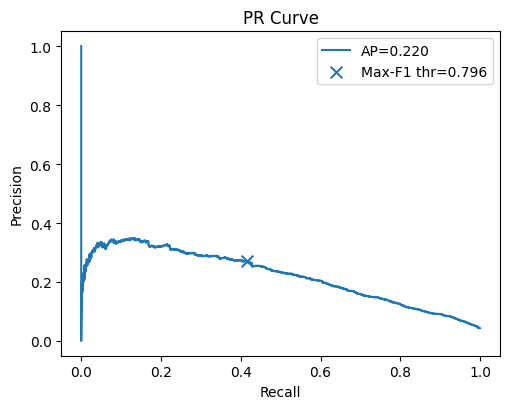

=== Test summary (LR) ===
auroc = 0.8471486395228235
average_precision = 0.22033477832015383
best_f1_threshold = 0.7962073287114356
youden_threshold = 0.5359768602445644
at_best_f1 = {'threshold': 0.7962073287114356, 'precision': 0.2712895377128954, 'recall': 0.41527001862197394, 'f1': 0.32818248712288445, 'accuracy': 0.9256847503154125, 'tp': 446, 'fp': 1198, 'tn': 22299, 'fn': 628}
at_youden = {'threshold': 0.5359768602445644, 'precision': 0.13894489247311828, 'recall': 0.7700186219739292, 'f1': 0.2354113293481355, 'accuracy': 0.7813682796792968, 'tp': 827, 'fp': 5125, 'tn': 18372, 'fn': 247}
Saved: models\m6a_logreg_20251013T174050Z.joblib


C:\Users\DELL\AppData\Local\Temp\ipykernel_7176\1104316798.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_logreg_20251013T174050Z.joblib')

In [6]:
from pathlib import Path
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

clf = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced", 
    random_state=42,
)

clf.fit(X_train, Y_train)

PLOT_PREFIX = "models/logreg"
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary = evaluate_sklearn_minimal(clf, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (LR) ===")
for k, v in summary.items():
    print(k, "=", v)

bundle = make_pipeline(scaler_pipeline, clf)
save_model_minimal({"pipeline": bundle, "feature_names": feature_names}, name="m6a_logreg")


### Gradient boost trees

scale_pos_weight ≈ 20.89
[LightGBM] [Info] Number of positive: 4475, number of negative: 93496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21347
[LightGBM] [Info] Number of data points in the train set: 97971, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.045677 -> initscore=-3.039412
[LightGBM] [Info] Start training from score -3.039412


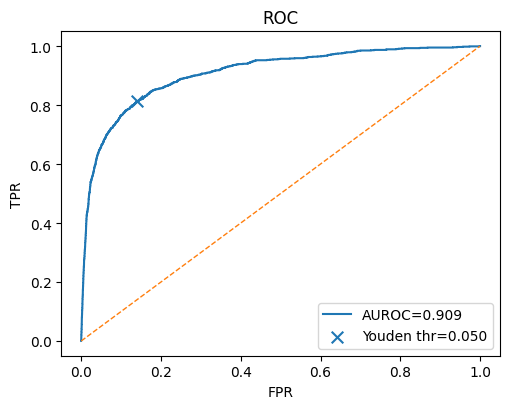

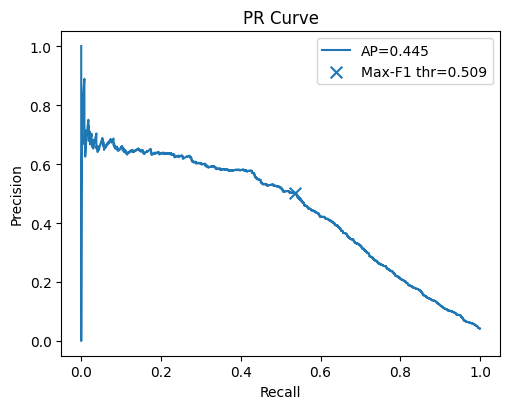

=== Test summary (LightGBM) ===
auroc = 0.9085067127301351
average_precision = 0.44494659753659616
best_f1_threshold = 0.5089574686733563
youden_threshold = 0.04976748756955394
at_best_f1 = {'threshold': 0.5089574686733563, 'precision': 0.5023386342376053, 'recall': 0.537, 'f1': 0.5190913484775254, 'accuracy': 0.9583106381195793, 'tp': 537, 'fp': 532, 'tn': 22335, 'fn': 463}
at_youden = {'threshold': 0.04976748756955394, 'precision': 0.20233947237431557, 'recall': 0.813, 'f1': 0.324033479473894, 'accuracy': 0.8578790799011187, 'tp': 813, 'fp': 3205, 'tn': 19662, 'fn': 187}
Saved: models\m6a_gbm_20251015T105908Z.joblib


C:\Users\DELL\AppData\Local\Temp\ipykernel_60488\1104316798.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_gbm_20251015T105908Z.joblib')

In [15]:
from pathlib import Path
import numpy as np
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier

pos_weight = (Y_train == 0).sum() / max(1, (Y_train == 1).sum())
print(f"scale_pos_weight ≈ {pos_weight:.2f}")

# Model
lgbm = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=30,
    objective="binary",
    scale_pos_weight=pos_weight,
    n_jobs=-1,
)

lgbm.fit(X_train, Y_train)

PLOT_PREFIX = "models/gbm"
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary_gbm = evaluate_sklearn_minimal(lgbm, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (LightGBM) ===")
for k, v in summary_gbm.items():
    print(k, "=", v)

deploy_bundle = make_pipeline(scaler_pipeline, lgbm)
save_model_minimal({"pipeline": deploy_bundle, "feature_names": feature_names}, name="m6a_gbm")


### Linear with ridge

[corr] dropped 28 / 87 columns (>|r|>0.95)
[univariate] selected top-40 by combined AUC+MI


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[l2] kept 59 non-zero features (of 59)
[final] 59 features selected


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


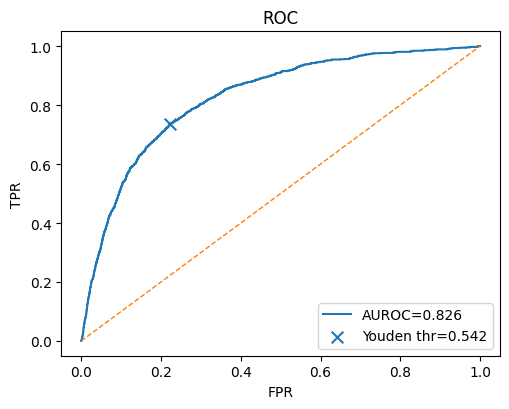

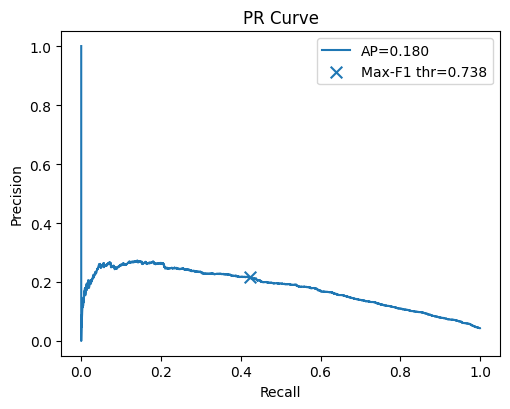

=== Test summary (L2 LR + feature selection) ===
auroc = 0.825726553784076
average_precision = 0.17970723236241812
best_f1_threshold = 0.7384885364408437
youden_threshold = 0.5421674760082255
at_best_f1 = {'threshold': 0.7384885364408437, 'precision': 0.21691352126134736, 'recall': 0.4227188081936685, 'f1': 0.2867066624565835, 'accuracy': 0.908062349924708, 'tp': 454, 'fp': 1639, 'tn': 21858, 'fn': 620}
at_youden = {'threshold': 0.5421674760082255, 'precision': 0.13154831199068684, 'recall': 0.7364990689013036, 'f1': 0.2232256243826725, 'accuracy': 0.7759553945708355, 'tp': 791, 'fp': 5222, 'tn': 18275, 'fn': 283}
Saved: models\m6a_logreg_L2_featselect_20251013T174803Z.joblib
[save] selected features → models\m6a_logreg_L2_featselect_features.txt


C:\Users\DELL\AppData\Local\Temp\ipykernel_7176\1104316798.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# ---------------- Config ----------------
CORR_THRESHOLD = 0.95
TOPK_UNIV      = 40
L2_C_GRID      = np.logspace(-2, 2, 7)
MODEL_NAME     = "m6a_logreg_L2_featselect"
PLOT_PREFIX    = "models/l2_featselect"

# ---------------- Helpers ----------------
def _safe_auc(y_true, x):
    x = pd.Series(x).replace([np.inf, -np.inf], np.nan)
    if x.isna().all() or x.nunique(dropna=True) < 2:
        return np.nan
    x = x.fillna(x.median())
    try:
        return roc_auc_score(y_true, x)
    except Exception:
        return np.nan

def _corr_prune(df: pd.DataFrame, thr: float) -> list[str]:
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thr)]
    kept = [c for c in df.columns if c not in to_drop]
    print(f"[corr] dropped {len(to_drop)} / {df.shape[1]} columns (>|r|>{thr})")
    return kept

# ---------------- 1) Correlation pruning on TRAIN ONLY ----------------
kept_after_corr = _corr_prune(X_train_df, CORR_THRESHOLD)
Xtr_corr = X_train_df[kept_after_corr]
Xte_corr = X_test_df[kept_after_corr]

# ---------------- 2) Univariate ranking (AUC + Mutual Information) ----------------
imp_uni = SimpleImputer(strategy="median")
Xtr_imp = pd.DataFrame(imp_uni.fit_transform(Xtr_corr), columns=kept_after_corr)

auc_scores = {c: _safe_auc(Y_train, Xtr_imp[c].values) for c in kept_after_corr}
auc_s = pd.Series(auc_scores).sort_values(ascending=False)

mi = mutual_info_classif(Xtr_imp.values, Y_train, discrete_features=False)
mi_s = pd.Series(mi, index=kept_after_corr).sort_values(ascending=False)

rank_auc = auc_s.rank(ascending=False, method="average")
rank_mi  = mi_s.rank(ascending=False, method="average")
combo_rank = (rank_auc + rank_mi).sort_values()
topk_univ = list(combo_rank.index[:min(TOPK_UNIV, len(combo_rank))])
print(f"[univariate] selected top-{len(topk_univ)} by combined AUC+MI")

# ---------------- 3) L2-Logistic selection (on pruned set) ----------------
l1cv = LogisticRegressionCV(
    Cs=L2_C_GRID,
    cv=3,
    penalty="l2",
    solver="saga",
    scoring="average_precision",
    class_weight="balanced",
    max_iter=5000,
    n_jobs=-1,
    refit=True,
)
l1cv.fit(Xtr_imp.values, Y_train)
coef = l1cv.coef_.ravel()
l1_kept_idx = np.where(coef != 0)[0]
l1_kept_feats = [kept_after_corr[i] for i in l1_kept_idx]
print(f"[l2] kept {len(l1_kept_feats)} non-zero features (of {len(kept_after_corr)})")

# ---------------- 4) Final feature set ----------------
final_feats = sorted(set(topk_univ).union(l1_kept_feats))
print(f"[final] {len(final_feats)} features selected")

X_train_sel = X_train_df[final_feats].copy()
X_test_sel  = X_test_df[final_feats].copy()

# ---------------- 5) Train L2 Logistic Regression (stable baseline) ----------------
pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        C=1.0,
        class_weight="balanced",
        tol=1e-4,
        max_iter=5000
    )),
])

pipe.fit(X_train_sel, Y_train)

# ---------------- 6) Evaluate + Save (using your minimal helpers) ----------------
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary = evaluate_sklearn_minimal(pipe, X_test_sel, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (L2 LR + feature selection) ===")
for k, v in summary.items():
    print(k, "=", v)

save_model_minimal(pipe, name=MODEL_NAME)

# Also save selected feature names for reproducibility
sel_path = Path("models") / f"{MODEL_NAME}_features.txt"
sel_path.write_text("\n".join(final_feats), encoding="utf-8")
print(f"[save] selected features → {sel_path}")


### MLP(batchnorm+droupout)

class_weight: {0: 0.523933258672975, 1: 10.945715036803366}
Epoch 1/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - auprc: 0.1423 - auroc: 0.7528 - loss: 0.5941 - val_auprc: 0.3640 - val_auroc: 0.8937 - val_loss: 0.2280 - learning_rate: 0.0010
Epoch 2/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auprc: 0.2849 - auroc: 0.8673 - loss: 0.4596 - val_auprc: 0.3897 - val_auroc: 0.9024 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 3/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auprc: 0.3342 - auroc: 0.8835 - loss: 0.4406 - val_auprc: 0.3983 - val_auroc: 0.9063 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 4/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auprc: 0.3661 - auroc: 0.8963 - loss: 0.4089 - val_auprc: 0.4080 - val_auroc: 0.9090 - val_loss: 0.3537 - learning_rate: 0.0010
Epoch 5/200
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auprc: 0.3623 - auroc: 0.8902 - loss: 0.4234 - val_auprc: 0.4247 - val_auroc: 0.9129 - val_loss: 0.3833 - learning_rate: 0.0010
Epoch 6/200
163/163 ━━━━━

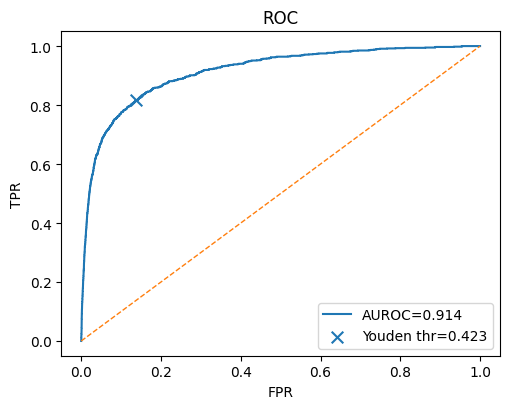

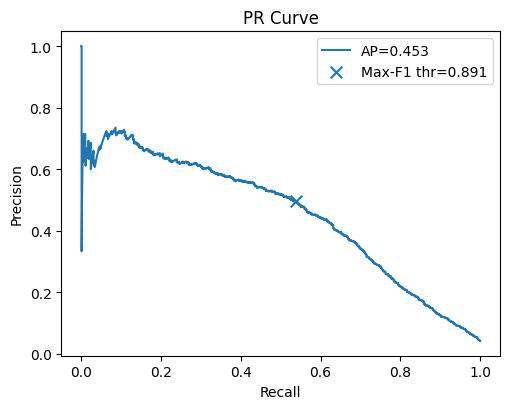

=== Test summary (MLP) ===
auroc = 0.9135618576988672
average_precision = 0.4532534799518093
best_f1_threshold = 0.8908253908157349
youden_threshold = 0.4233973026275635
at_best_f1 = {'threshold': 0.8908253908157349, 'precision': 0.49586016559337626, 'recall': 0.539, 'f1': 0.5165309056061332, 'accuracy': 0.9577240541333222, 'tp': 539, 'fp': 548, 'tn': 22319, 'fn': 461}
at_youden = {'threshold': 0.4233973026275635, 'precision': 0.2076238881829733, 'recall': 0.817, 'f1': 0.3311043566362715, 'accuracy': 0.8616918758117903, 'tp': 817, 'fp': 3118, 'tn': 19749, 'fn': 183}
Saved: models\m6a_keras_mlp_20251015T104303Z.keras


C:\Users\DELL\AppData\Local\Temp\ipykernel_60488\1104316798.py:102: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_keras_mlp_20251015T104303Z.keras')

In [10]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------- Config ----------------
VAL_SIZE     = 0.15
RANDOM_STATE = 42
MODEL_NAME   = "m6a_keras_mlp"
PLOT_PREFIX  = "models/mlp"

# ---------------- Build MLP ----------------
def build_mlp(input_dim, dropout=0.3, lr=1e-3, l2_weight=1e-5):
    inp = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)
    for width in [256, 128, 64]:
        x = layers.Dense(width, activation=None,
                         kernel_regularizer=keras.regularizers.l2(l2_weight))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.AUC(curve="PR", name="auprc"),
            keras.metrics.AUC(curve="ROC", name="auroc"),
        ],
    )
    return model

# ---------------- Train/Val split (from TRAIN only) ----------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
tr_idx, val_idx = next(sss.split(X_train, Y_train))
X_tr, Y_tr = X_train[tr_idx], Y_train[tr_idx]
X_val, Y_val = X_train[val_idx], Y_train[val_idx]

# ---------------- Class weights for imbalance ----------------
classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=Y_tr)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("class_weight:", class_weight)

# ---------------- Build & fit ----------------
model = build_mlp(input_dim=X_train.shape[1], dropout=0.3, lr=1e-3, l2_weight=1e-5)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auprc", mode="max",
        patience=12, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auprc", mode="max",
        factor=0.5, patience=6, min_lr=1e-5, verbose=1
    ),
]

history = model.fit(
    X_tr, Y_tr,
    validation_data=(X_val, Y_val),
    epochs=200,
    batch_size=512,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1,
)

# ---------------- Evaluate with your helper ----------------
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)
summary = evaluate_keras_minimal(model, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("=== Test summary (MLP) ===")
for k, v in summary.items():
    print(k, "=", v)

# ---------------- Save with your Keras helper ----------------
save_keras_minimal(model, name=MODEL_NAME, models_dir="models")


In [7]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --------- Config ---------
VAL_SIZE      = 0.15
RANDOM_STATE  = 42
N_TRIALS      = 20
EPOCHS        = 200
PATIENCE_ES   = 12
PATIENCE_RLR  = 6
MODEL_NAME    = "m6a_keras_mlp_tuned"
PLOT_PREFIX   = "models/mlp_tuned"
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)

# --------- Train/Val split (from TRAIN only) ---------
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
tr_idx, val_idx = next(sss.split(X_train, Y_train))
X_tr, Y_tr = X_train[tr_idx], Y_train[tr_idx]
X_val, Y_val = X_train[val_idx], Y_train[val_idx]

# --------- Class weights for imbalance ---------
classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=Y_tr)
class_weight = {0: float(weights[0]), 1: float(weights[1])}
print("class_weight:", class_weight)

# --------- Search space ---------
WIDTH_SETS = [
    [256, 128, 64],
    [512, 256, 128],
    [256, 256, 128],
    [128, 128, 64],
]
DROPOUTS = [0.2, 0.3, 0.4]
L2S      = [1e-6, 1e-5, 1e-4]
LRS      = [5e-4, 1e-3, 2e-3]
BATCHES  = [256, 512, 1024]

rng = np.random.default_rng(RANDOM_STATE)

def sample_hparams():
    return {
        "widths": WIDTH_SETS[rng.integers(len(WIDTH_SETS))],
        "dropout": float(rng.choice(DROPOUTS)),
        "l2": float(rng.choice(L2S)),
        "lr": float(rng.choice(LRS)),
        "batch_size": int(rng.choice(BATCHES)),
    }

# --------- Model builder ---------
def build_mlp(input_dim, widths, dropout, l2_weight, lr):
    inp = keras.Input(shape=(input_dim,))
    x = layers.BatchNormalization()(inp)
    for w in widths:
        x = layers.Dense(w, activation=None,
                         kernel_regularizer=keras.regularizers.l2(l2_weight))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(curve="PR", name="auprc"),
                 keras.metrics.AUC(curve="ROC", name="auroc")],
    )
    return model

# --------- Callbacks factory ---------
def make_callbacks():
    return [
        keras.callbacks.EarlyStopping(
            monitor="val_auprc", mode="max", patience=PATIENCE_ES, restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_auprc", mode="max", factor=0.5, patience=PATIENCE_RLR,
            min_lr=1e-5, verbose=1
        ),
    ]

# --------- Random search ---------
trial_results = []
best = {"val_auprc": -np.inf, "model": None, "hparams": None}

for t in range(1, N_TRIALS + 1):
    hp = sample_hparams()
    print(f"\n=== Trial {t}/{N_TRIALS} ===")
    print(hp)

    # build & train
    model = build_mlp(
        input_dim=X_train.shape[1],
        widths=hp["widths"],
        dropout=hp["dropout"],
        l2_weight=hp["l2"],
        lr=hp["lr"],
    )

    history = model.fit(
        X_tr, Y_tr,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,
        batch_size=hp["batch_size"],
        class_weight=class_weight,
        callbacks=make_callbacks(),
        verbose=0,  # make 1 if you want to see per-epoch logs
    )

    # record best val PR-AUC this run
    val_auprc = float(np.max(history.history["val_auprc"]))
    val_auroc = float(np.max(history.history.get("val_auroc", [-np.inf])))
    trial_results.append({"trial": t, "val_auprc": val_auprc, "val_auroc": val_auroc, **hp})
    print(f"-> best val_auprc: {val_auprc:.4f} | best val_auroc: {val_auroc:.4f}")

    if val_auprc > best["val_auprc"]:
        best.update({"val_auprc": val_auprc, "model": model, "hparams": hp})

# --------- Report top trials ---------
trial_results = sorted(trial_results, key=lambda d: d["val_auprc"], reverse=True)
print("\nTop 5 trials by val_auprc:")
for r in trial_results[:5]:
    print(r)

# --------- Evaluate BEST on TEST and save ---------
best_model = best["model"]
print("\nBest hparams:", best["hparams"])
print("Best val_auprc:", best["val_auprc"])

summary = evaluate_keras_minimal(best_model, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("\n=== Test summary (best MLP) ===")
for k, v in summary.items():
    print(k, "=", v)

save_keras_minimal(best_model, name=MODEL_NAME, models_dir="models")


class_weight: {0: 0.523933258672975, 1: 10.945715036803366}

=== Trial 1/20 ===
{'widths': [256, 128, 64], 'dropout': 0.4, 'l2': 1e-05, 'lr': 0.001, 'batch_size': 512}

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 76: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
-> best val_auprc: 0.5099 | best val_auroc: 0.9304

=== Trial 2/20 ===
{'widths': [128, 128, 64], 'dropout': 0.2, 'l2': 0.0001, 'lr': 0.0005, 'batch_size': 256}

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
-> best val_auprc: 0.5004 | best val_auroc: 0.9275

=== Trial 3/20 ===
{'widths': [256, 256, 128], 'dropout': 0.4, 'l2': 0.0001, 'lr': 0.002, 'batch_size': 1024}

Epoch 27: ReduceLROnPlateau reducing lear

NameError: name 'evaluate_keras_minimal' is not defined


Best hparams: {'widths': [512, 256, 128], 'dropout': 0.2, 'l2': 1e-06, 'lr': 0.001, 'batch_size': 1024}
Best val_auprc: 0.519051194190979
746/746 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step


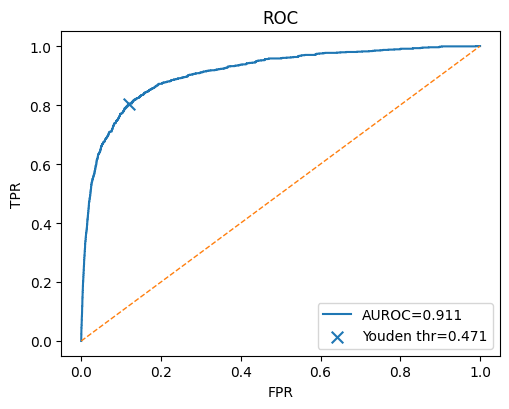

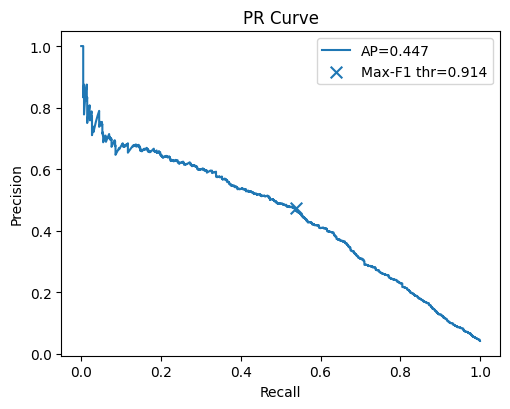


=== Test summary (best MLP) ===
auroc = 0.9108753881138759
average_precision = 0.447398087659879
best_f1_threshold = 0.9144271612167358
youden_threshold = 0.4712049067020416
at_best_f1 = {'threshold': 0.9144271612167358, 'precision': 0.4723441615452151, 'recall': 0.538, 'f1': 0.5030388031790556, 'accuracy': 0.9554615159006159, 'tp': 538, 'fp': 601, 'tn': 22266, 'fn': 462}
at_youden = {'threshold': 0.4712049067020416, 'precision': 0.22882319499715748, 'recall': 0.805, 'f1': 0.3563523683045595, 'accuracy': 0.8781581262831525, 'tp': 805, 'fp': 2713, 'tn': 20154, 'fn': 195}
Saved: models\m6a_keras_mlp_tuned_20251015T104035Z.keras


C:\Users\DELL\AppData\Local\Temp\ipykernel_60488\1104316798.py:102: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_keras_mlp_tuned_20251015T104035Z.keras')

In [9]:
best_model = best["model"]
print("\nBest hparams:", best["hparams"])
print("Best val_auprc:", best["val_auprc"])

summary = evaluate_keras_minimal(best_model, X_test, Y_test, plot_prefix=PLOT_PREFIX)
print("\n=== Test summary (best MLP) ===")
for k, v in summary.items():
    print(k, "=", v)

save_keras_minimal(best_model, name=MODEL_NAME, models_dir="models")

Loaded read-level examples: 121838 sites | positives=5475 | negatives=116363
[split] grouping by gene_id
Train/Val/Test sizes: 83305/14701/23832

class_weight: {0: 0.52289161163976, 1: 11.421030984370717}
Epoch 1/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - auprc: 0.1374 - auroc: 0.7473 - loss: 0.5964 - val_auprc: 0.2009 - val_auroc: 0.7832 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 2/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - auprc: 0.2138 - auroc: 0.8128 - loss: 0.5268 - val_auprc: 0.1438 - val_auroc: 0.8090 - val_loss: 0.2594 - learning_rate: 0.0010
Epoch 3/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - auprc: 0.2586 - auroc: 0.8289 - loss: 0.5078 - val_auprc: 0.3410 - val_auroc: 0.8333 - val_loss: 0.5750 - learning_rate: 0.0010
Epoch 4/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - auprc: 0.2764 - auroc: 0.8496 - loss: 0.4798 - val_auprc: 0.3479 - val_auroc: 0.8727 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 5/200
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - aup

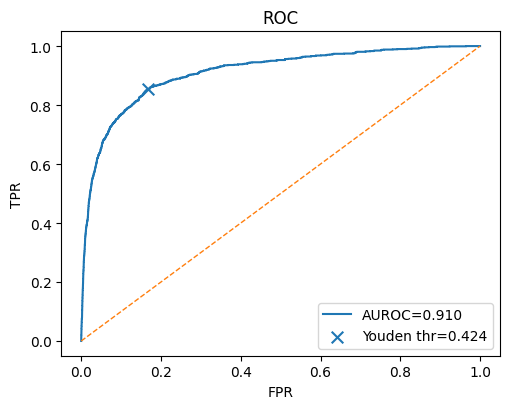

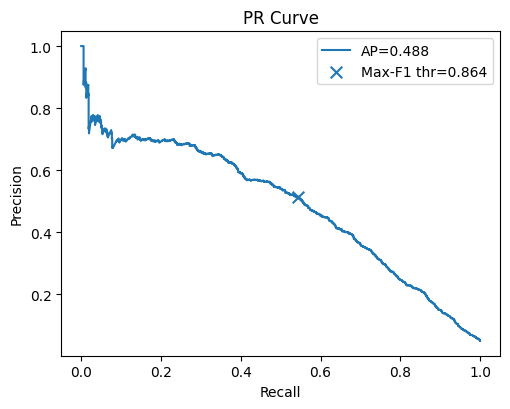

=== Test summary (DeepSets) ===
auroc = 0.9103660188358617
average_precision = 0.4875714630345695
best_f1_threshold = 0.863650918006897
youden_threshold = 0.4240112900733948
at_best_f1 = {'threshold': 0.863650918006897, 'precision': 0.5143540669856459, 'recall': 0.5447635135135135, 'f1': 0.5291222313371616, 'accuracy': 0.9518294729775092, 'tp': 645, 'fp': 609, 'tn': 22039, 'fn': 539}
at_youden = {'threshold': 0.4240112900733948, 'precision': 0.2113294314381271, 'recall': 0.8538851351351351, 'f1': 0.33880697050938335, 'accuracy': 0.834424303457536, 'tp': 1011, 'fp': 3773, 'tn': 18875, 'fn': 173}
Saved: models\m6a_deepsets_20251015T105321Z.keras


C:\Users\DELL\AppData\Local\Temp\ipykernel_60488\1104316798.py:102: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")


WindowsPath('models/m6a_deepsets_20251015T105321Z.keras')

In [11]:
import json, gzip, io, os
from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
import pandas as pd

# ---------- Config ----------
DATA_DIR     = Path("data")
JSON_PATH    = DATA_DIR / "dataset0.json.gz"
LABELS_PATH  = DATA_DIR / "data.info.labelled"
TEST_SIZE    = 0.20
VAL_SIZE     = 0.15
RANDOM_STATE = 42
MAX_READS    = 64
READ_DIM     = 9
MODEL_NAME   = "m6a_deepsets"
PLOT_PREFIX  = "models/deepsets"

label_dtypes = {
    "gene_id": "string",
    "transcript_id": "string",
    "transcript_position": "int32",
    "label": "int8",
}
df_info = pd.read_csv(LABELS_PATH, dtype=label_dtypes)
labels_map: Dict[Tuple[str, int], Tuple[int, str]] = {
    (row.transcript_id, int(row.transcript_position)): (int(row.label), str(row.gene_id))
    for row in df_info.itertuples(index=False)
}

def _open_text(path: Path):
    return gzip.open(path, "rt", encoding="utf-8")

def _iter_records(path: Path):
    """
    Yields dict records of the form:
      { transcript_id: { position: { heptamer: [[9], [9], ...] } } }
    Supports gzipped JSONL, or a single big JSON array.
    """
    with _open_text(path) as f:
        buf = f.read(2048)
        if not buf.strip():
            return
        first_char = next((ch for ch in buf if not ch.isspace()), "")
        if first_char == "{":
            f2 = gzip.open(path, "rt", encoding="utf-8")
            for line in f2:
                line = line.strip()
                if line:
                    yield json.loads(line)
            f2.close()
        else:
            f2 = gzip.open(path, "rt", encoding="utf-8")
            data = json.load(f2)
            f2.close()
            if isinstance(data, list):
                for obj in data:
                    yield obj
            else:
                yield data

# ---------- 2) Extract labeled examples ----------
def extract_examples(json_path: Path, max_reads: int = MAX_READS) -> List[Dict]:
    out = []
    for obj in _iter_records(json_path):
        tid = next(iter(obj))
        tblock = obj[tid]
        pos_key = next(iter(tblock))
        pos = int(pos_key)
        hept_map = tblock[str(pos)] if str(pos) in tblock else tblock[pos]
        heptamer = next(iter(hept_map))
        reads = hept_map[heptamer]
        key = (tid, pos)
        if key not in labels_map:
            continue
        label, gid = labels_map[key]
        # keep only proper 9-dim numeric reads
        clean_reads = []
        for r in reads:
            if isinstance(r, (list, tuple)) and len(r) == READ_DIM:
                try:
                    clean_reads.append([float(x) for x in r])
                except Exception:
                    continue
        if not clean_reads:
            continue
        out.append({
            "gene_id": gid,
            "transcript_id": tid,
            "transcript_position": pos,
            "heptamer": heptamer,
            "reads": clean_reads[:max_reads],  # truncate
            "n_reads": len(clean_reads),
            "label": int(label),
        })
    return out

examples = extract_examples(JSON_PATH, max_reads=MAX_READS)
if not examples:
    raise RuntimeError("No labeled examples found. Check dataset0.json.gz and data.info.labelled alignment.")

df = pd.DataFrame(examples)
print(f"Loaded read-level examples: {len(df)} sites | positives={df['label'].sum()} | negatives={(df['label']==0).sum()}")

# ---------- 3) Pad to fixed size tensors ----------
def pad_reads(reads_list: List[List[float]], max_reads: int, feat_dim: int):
    R = max_reads
    arr = np.zeros((R, feat_dim), dtype=np.float32)
    mask = np.zeros((R,), dtype=bool)
    L = min(len(reads_list), R)
    if L > 0:
        arr[:L, :] = np.asarray(reads_list[:L], dtype=np.float32)
        mask[:L] = True
    return arr, mask

reads_arr = np.zeros((len(df), MAX_READS, READ_DIM), dtype=np.float32)
mask_arr  = np.zeros((len(df), MAX_READS), dtype=bool)
for i, rlist in enumerate(df["reads"]):
    a, m = pad_reads(rlist, MAX_READS, READ_DIM)
    reads_arr[i] = a
    mask_arr[i]  = m

y_all = df["label"].astype(int).to_numpy()

# ---------- 4) Group-aware splits ----------
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

if "gene_id" in df.columns:
    groups = df["gene_id"].astype(str).values
    print("[split] grouping by gene_id")
else:
    groups = df["transcript_id"].astype(str).values
    print("[split] grouping by transcript_id")

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(reads_arr, y_all, groups=groups))

sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=RANDOM_STATE)
tr_local_idx, val_local_idx = next(sss.split(train_idx.reshape(-1,1), y_all[train_idx]))
tr_idx  = train_idx[tr_local_idx]
val_idx = train_idx[val_local_idx]

Xtr_reads, Xtr_mask, y_tr   = reads_arr[tr_idx],  mask_arr[tr_idx],  y_all[tr_idx]
Xval_reads, Xval_mask, y_val= reads_arr[val_idx], mask_arr[val_idx], y_all[val_idx]
Xte_reads, Xte_mask, y_te   = reads_arr[test_idx], mask_arr[test_idx], y_all[test_idx]

print(f"Train/Val/Test sizes: {len(tr_idx)}/{len(val_idx)}/{len(test_idx)}")

# ---------- 5) DeepSets (Keras 3–friendly attention pooling) ----------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight

def build_deepsets(read_dim=READ_DIM, max_reads=MAX_READS, dropout=0.2, lr=1e-3, hidden=128):
    reads_in = keras.Input(shape=(max_reads, read_dim), name="reads")      # (B, R, 9)
    mask_in  = keras.Input(shape=(max_reads,), dtype="bool", name="mask")  # (B, R)

    # Per-read encoder
    x = layers.Dense(hidden, activation=None)(reads_in)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden, activation="relu")(x)   # (B, R, H)

    # Attention pooling with mask (all via Keras layers / ops)
    logits = layers.Dense(1)(x)                      # (B, R, 1)
    mask_f = layers.Lambda(lambda m: keras.ops.expand_dims(keras.ops.cast(m, "float32"), axis=-1))(mask_in)  # (B,R,1)
    neg_inf = layers.Lambda(lambda m: (1.0 - m) * (-1e9))(mask_f)
    masked_logits = layers.Add()([logits, neg_inf])  # (B, R, 1)
    att = layers.Softmax(axis=1)(masked_logits)      # (B, R, 1)
    weighted = layers.Multiply()([att, x])           # (B, R, H)
    pooled = layers.Lambda(lambda t: keras.ops.sum(t, axis=1))(weighted)   # (B, H)

    # Head
    h = layers.Dense(hidden, activation="relu")(pooled)
    h = layers.Dropout(dropout)(h)
    out = layers.Dense(1, activation="sigmoid")(h)

    model = keras.Model(inputs=[reads_in, mask_in], outputs=out)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.AUC(curve="PR", name="auprc"),
                 keras.metrics.AUC(curve="ROC", name="auroc")]
    )
    return model

# GPU memory growth (optional)
for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

model = build_deepsets()

# Class weights for imbalance
classes = np.array([0, 1])
w = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight = {0: float(w[0]), 1: float(w[1])}
print("class_weight:", class_weight)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auprc", mode="max", patience=12, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auprc", mode="max", factor=0.5, patience=6, min_lr=1e-5, verbose=1),
]

history = model.fit(
    x=[Xtr_reads, Xtr_mask], y=y_tr,
    validation_data=([Xval_reads, Xval_mask], y_val),
    epochs=200, batch_size=128,
    class_weight=class_weight,
    callbacks=callbacks, verbose=1
)

# ---------- 6) Evaluate & Save ----------
Path(PLOT_PREFIX).parent.mkdir(parents=True, exist_ok=True)

summary = evaluate_keras_minimal(model, [Xte_reads, Xte_mask], y_te, plot_prefix=PLOT_PREFIX)
print("=== Test summary (DeepSets) ===")
for k, v in summary.items():
    print(k, "=", v)

save_keras_minimal(model, name=MODEL_NAME, models_dir="models")


In [ ]:
# ============================================
# Predict with DeepSets (.keras) on dataset0/1/2 raw m6Anet JSON(.gz)
# - Loads model via tf.saved_model.load (avoids Keras Lambda issues)
# - Parses raw JSON -> per-site padded tensors: (N, MAX_READS, 9) + mask (N, MAX_READS)
# - Runs batched inference
# - Writes 3 CSVs: transcript_id, transcript_position, score
# ============================================

import json, gzip
from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import tensorflow as tf

# -------- Config --------
DATA_DIR   = Path("data")
DATASETS   = ["dataset0.json.gz", "dataset1.json.gz", "dataset2.json.gz"]
MODEL_PATH =  Path("models") / "m6a_deepsets_20251015T105321Z.keras"
MAX_READS  = 64     # must match training
READ_DIM   = 9      # m1/c/p1 × (dt,sd,mean)
BATCH_SIZE = 256

# -------- Load model as SavedModel --------
loaded = tf.saved_model.load(MODEL_PATH)
infer = loaded.signatures["serving_default"]
print("Loaded model:", MODEL_PATH)
print("Signature inputs:", infer.structured_input_signature)
print("Signature outputs:", infer.structured_outputs)

def _resolve_io_names(infer_fn):
    """Try to identify the reads/mask input keys robustly."""
    in_keys = list(infer_fn.structured_inputs.keys())  # dict-like
    # Prefer explicit names if present
    reads_key = None
    mask_key  = None
    for k in in_keys:
        k_lower = k.lower()
        if "read" in k_lower and reads_key is None:
            reads_key = k
        if "mask" in k_lower and mask_key is None:
            mask_key = k
    # Fallback by shape/dtype: reads = float, rank 3; mask = bool, rank 2 or 3 (we used rank 2)
    if reads_key is None or mask_key is None:
        sig = infer_fn.structured_input_signature[1]  # dict of TensorSpec
        for k, spec in sig.items():
            if hasattr(spec, "dtype") and hasattr(spec, "shape"):
                if spec.dtype.is_floating and len(spec.shape) == 3:
                    reads_key = reads_key or k
                if spec.dtype == tf.bool and len(spec.shape) in (2, 3):
                    mask_key = mask_key or k
    if reads_key is None or mask_key is None:
        raise RuntimeError(f"Could not infer input keys for reads/mask from signature keys={in_keys}")
    out_key = list(infer_fn.structured_outputs.keys())[0]
    return reads_key, mask_key, out_key

READS_KEY, MASK_KEY, OUT_KEY = _resolve_io_names(infer)
print("Resolved keys -> reads:", READS_KEY, "| mask:", MASK_KEY, "| output:", OUT_KEY)

# -------- JSON reader (gz JSONL or gz JSON array/dict) --------
def iter_records_gz(path: Path):
    with gzip.open(path, "rt", encoding="utf-8") as f:
        first = f.readline()
        if not first:
            return
        s = first.strip()
        if s.startswith("{"):
            # JSONL
            yield json.loads(s)
            for line in f:
                line = line.strip()
                if line:
                    yield json.loads(line)
        else:
            f.seek(0)
            data = json.load(f)
            if isinstance(data, list):
                for obj in data:
                    yield obj
            else:
                yield data

# -------- Build per-site tensors (reads, mask) --------
def pad_reads(reads_list: List[List[float]], max_reads: int, feat_dim: int) -> Tuple[np.ndarray, np.ndarray]:
    R = max_reads
    arr = np.zeros((R, feat_dim), dtype=np.float32)
    mask = np.zeros((R,), dtype=bool)
    L = min(len(reads_list), R)
    if L > 0:
        arr[:L, :] = np.asarray(reads_list[:L], dtype=np.float32)
        mask[:L] = True
    return arr, mask

def parse_dataset(json_path: Path, max_reads: int = MAX_READS) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Returns:
      df_info: columns [transcript_id, transcript_position]
      reads_arr: (N, MAX_READS, 9)
      mask_arr:  (N, MAX_READS) boolean
    """
    tids, poss = [], []
    reads_list = []
    for obj in iter_records_gz(json_path):
        # obj: { transcript_id: { position: { heptamer: [[9], [9], ...] } } }
        tid = next(iter(obj))
        pos_map = obj[tid]
        pos_key = next(iter(pos_map))
        pos = int(pos_key)
        hept_map = pos_map[str(pos)] if str(pos) in pos_map else pos_map[pos]
        heptamer = next(iter(hept_map))
        reads = hept_map[heptamer]

        clean = []
        for r in reads:
            if isinstance(r, (list, tuple)) and len(r) == READ_DIM:
                try:
                    clean.append([float(x) for x in r])
                except Exception:
                    continue
        if not clean:
            continue

        tids.append(tid)
        poss.append(pos)
        reads_list.append(clean)

    N = len(reads_list)
    if N == 0:
        return pd.DataFrame(columns=["transcript_id", "transcript_position"]), \
               np.zeros((0, max_reads, READ_DIM), dtype=np.float32), \
               np.zeros((0, max_reads), dtype=bool)

    reads_arr = np.zeros((N, max_reads, READ_DIM), dtype=np.float32)
    mask_arr  = np.zeros((N, max_reads), dtype=bool)
    for i, rl in enumerate(reads_list):
        a, m = pad_reads(rl, max_reads, READ_DIM)
        reads_arr[i] = a
        mask_arr[i]  = m

    df_info = pd.DataFrame({
        "transcript_id": np.array(tids, dtype=str),
        "transcript_position": np.array(poss, dtype=np.int32),
    })
    return df_info, reads_arr, mask_arr

# -------- Batched inference with SavedModel signature --------
def predict_deepsets(infer_fn, reads_np: np.ndarray, mask_np: np.ndarray, batch_size: int = BATCH_SIZE) -> np.ndarray:
    """
    reads_np: (N, MAX_READS, 9) float32
    mask_np:  (N, MAX_READS)    bool
    Returns scores: (N,) float32
    """
    N = reads_np.shape[0]
    outs = []
    for i in range(0, N, batch_size):
        sl = slice(i, min(i + batch_size, N))
        feed = {
            READS_KEY: tf.convert_to_tensor(reads_np[sl], dtype=tf.float32),
            MASK_KEY:  tf.convert_to_tensor(mask_np[sl],  dtype=tf.bool),
        }
        out = infer_fn(**feed)[OUT_KEY].numpy().reshape(-1)
        outs.append(out)
    return np.concatenate(outs, axis=0) if outs else np.zeros((0,), dtype=np.float32)

# -------- Run predictions for each dataset --------
for fname in DATASETS:
    in_path = DATA_DIR / fname
    out_csv = DATA_DIR / f"predictions_{fname.replace('.json.gz','')}.csv"
    print(f"\nParsing {in_path} …")
    df_info, reads_arr, mask_arr = parse_dataset(in_path, MAX_READS)
    print(f"Sites: {len(df_info)}")

    if len(df_info) == 0:
        print(f"[WARN] No sites parsed for {fname}; skipping write.")
        continue

    print("Predicting …")
    scores = predict_deepsets(infer, reads_arr, mask_arr, batch_size=BATCH_SIZE)

    pred = pd.DataFrame({
        "transcript_id": df_info["transcript_id"].astype(str),
        "transcript_position": df_info["transcript_position"].astype(int),
        "score": scores.astype(float)
    })
    pred.to_csv(out_csv, index=False)
    print(f"Wrote: {out_csv}  ({len(pred)} rows)")


OSError: SavedModel file does not exist at: models\m6a_deepsets_20251015T105321Z.keras\{saved_model.pbtxt|saved_model.pb}